## Mask R-CNN - Inspect DoReMi Training data

In [3]:
import os
import sys
import random
import math
import re
import glob
import time
import numpy as np
import datetime
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from tqdm import tqdm
from xml.dom import minidom
from mrcnn.config import Config

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn.utils import Dataset
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

import skimage.draw
from keras import backend as K

# Path to classnames file
CLASSNAMES_PATH = "/import/c4dm-05/elona/doremi_v5_half/train_validation_test_records/mapping.json"

# Path to XML Train files
XML_DATA_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/dataset/'
# XML_TRAIN_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/dataset/train/'
# Path to XML Val files
# XML_VAL_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/dataset/val/'

# Path to Images 
IMG_PATH = '/homes/es314/DOREMI_version_2/DOREMI_v3/images/'
# Path to trained weights file
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
COCO_WEIGHTS_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/weights/mask_rcnn_coco.h5'
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = '/import/c4dm-05/elona/maskrcnn-logs/logs_all_layers_101/doremi20210504T0325/'

Using TensorFlow backend.


In [4]:
class DoremiConfig(Config):
    """
    Configuration for training on the Doremi dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "doremi"

    # We use a GPU with ??GB memory, which can fit ??? images. (12gb can fit 2 images)
    # Adjust down if you use a smaller/bigger GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 71  # Background + 71 classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.6

    # Our image size 
    # IMAGE_RESIZE_MODE = "crop"
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_DIM = 1024
    IMAGE_SHAPE = (IMAGE_MIN_DIM, IMAGE_MAX_DIM)
    BACKBONE = "resnet101"

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
# DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

DEVICE = "/cpu:0"

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
#original size=16
def get_ax(rows=1, cols=1, size=50):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
class DoremiDataset(utils.Dataset):
    def load_doremi(self, subset):
        """
        Load a subset of the Foremi dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        # self.add_class("doremi", class_id, "classname")
        with open(CLASSNAMES_PATH) as json_file:
            data = json.load(json_file)
            for id_class in data:
                self.add_class("doremi", id_class["id"], id_class["name"])

        # Train or validation dataset?
        assert subset in ["train", "val"]
        # dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir = XML_DATA_PATH+subset+'/*.xml'
        available_xml = glob.glob(dataset_dir)
        # xml_count = len(available_xml)

        # Go through all XML Files
        # Each XML File is 1 Page, each page corresponds to 1 image
        for xml_file in tqdm(available_xml, desc="XML Files"):
            filename = os.path.basename(xml_file)
            # Remove .xml from end of file
            filename = filename[:-4]

            # Parse XML Document
            xmldoc = minidom.parse(xml_file)

            # Get image name from XML file name
            page = xmldoc.getElementsByTagName('Page')
            page_index_str = page[0].attributes['pageIndex'].value

            page_index_int = int(page_index_str) + 1
            # Open image related to XML file
            # /homes/es314/DOREMI_version_2/data_v5/parsed_by_classnames/Parsed_accidental tucking-layout-0-muscima_Page_2.xml
            # Parsed_accidental tucking-layout-0-muscima_Page_2.xml
            # Remove '-layout-0-muscima_Page_' (23 chars) + len of page_index_str

            # Image name
            # /homes/es314/DOREMI_version_2/DOREMI_v3/images/accidental tucking-002.png
            # accidental tucking-002.png

            ending = 23 + len(str(page_index_int))

            start_str = 'Parsed_'
            # If page is 0, we need to add '000'
            leading_zeroes = str(page_index_int).zfill(3)
            img_filename = filename[len(start_str):-ending]+'-'+leading_zeroes
            img_filename = img_filename+'.png'
            # /homes/es314/DOREMI_version_2/DOREMI_v3/images/beam groups 12 demisemiquavers simple-918.png'

            img_path = IMG_PATH + img_filename
            # Hardcoded because our images have the same shape
            img_height = 3504
            img_width = 2474

            mask_arr = []

            nodes = xmldoc.getElementsByTagName('Node')
            # print('nodes len: ', len(nodes))

            instances_count = len(xmldoc.getElementsByTagName('ClassName'))

            # Array containing mask info object that we will use in load_mask
            masks_info = []
            # {
            #     "bbox_top": int
            #     "bbox_left": int
            #     "bbox_width": int
            #     "bbox_height": int
            #     "mask_arr": [int]
            #     "classname": str
            # }
            for node in nodes:
                this_mask_info = {}
                # Classname
                node_classname_el = node.getElementsByTagName('ClassName')[0]
                node_classname = node_classname_el.firstChild.data
                # Top
                node_top = node.getElementsByTagName('Top')[0]
                node_top_int = int(node_top.firstChild.data)
                # Left
                node_left = node.getElementsByTagName('Left')[0]
                node_left_int = int(node_left.firstChild.data)
                # Width
                node_width = node.getElementsByTagName('Width')[0]
                node_width_int = int(node_width.firstChild.data)
                # Height
                node_height = node.getElementsByTagName('Height')[0]
                node_height_int = int(node_height.firstChild.data)

                node_mask = str(node.getElementsByTagName('Mask')[0].firstChild.data)
                # 0: 2 1: 7 0: 9 1: 3
                node_mask = node_mask.replace('0:', '')
                # 2 1: 7 9 1: 3
                node_mask = node_mask.replace('1:', '')
                # 2 7 9 3
                split_mask = node_mask.split(' ')
                # [2, 7, 9, 3]
                split_mask = split_mask[:-1]
                
                notehead_counts = list(map(int, list(split_mask)))

                this_mask_info["classname"] = node_classname
                this_mask_info["bbox_top"] = node_top_int
                this_mask_info["bbox_left"] = node_left_int
                this_mask_info["bbox_width"] = node_width_int
                this_mask_info["bbox_height"] = node_height_int
                this_mask_info["mask_arr"] = notehead_counts

                masks_info.append(this_mask_info)


            # 3 required attributes, rest is kwargs
            # image_info = {
            #     "id": image_id,
            #     "source": source,
            #     "path": path,
            # }
            self.add_image(
                    "doremi",
                    image_id=img_filename,  # use file name as a unique image id
                    path=img_path,
                    img_width=img_width, img_height=img_height,
                    masks_info=masks_info)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Should returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        if info["source"] != "doremi":
            return super(self.__class__, self).load_mask(image_id)
        
        img_height = info["img_height"]
        img_width = info["img_width"]
        mask = np.zeros([img_height, img_width, len(info["masks_info"])],dtype=np.uint8)
        instances_classes = []
        ids_classnames = {}
        with open(CLASSNAMES_PATH) as json_file:
            data = json.load(json_file)
            for id_class in data:
                ids_classnames[id_class["name"]] = id_class["id"]
        for it, info in enumerate(info["masks_info"]):
            class_id = ids_classnames[info["classname"]]
            instances_classes.append(class_id)

            notehead_counts = info["mask_arr"]
            node_top_int = info["bbox_top"]
            node_left_int = info["bbox_left"]
            node_width_int = info["bbox_width"]
            node_height_int = info["bbox_height"]
            # Counts start with Zero
            zero = True
            i = node_top_int
            j = node_left_int

            for count in notehead_counts:
                # If first 0 count is zero, ignore and go to 1
                if count != 0:
                    for _ in range(count):
                        if not zero:
                            mask[i, j, it] = 1

                        j = j + 1
                        if j == img_width or j == node_left_int+node_width_int:
                            j = node_left_int
                            i = i + 1
                zero = not zero
        # Return mask, and array of class IDs of each instance.
        return mask.astype(np.bool), np.array(instances_classes, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "doremi":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [8]:
 # Training dataset.
dataset_train = DoremiDataset()
dataset_train.load_doremi("train")
dataset_train.prepare()

# Validation dataset
dataset_val = DoremiDataset()
dataset_val.load_doremi("val")
dataset_val.prepare()

XML Files: 100%|██████████| 88/88 [00:01<00:00, 57.08it/s]


In [9]:
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 291
Class Count: 72
  0. BG                                                
  1. accidentalDoubleFlat                              
  2. accidentalDoubleSharp                             
  3. accidentalFlat                                    
  4. accidentalNatural                                 
  5. accidentalQuarterToneFlatStein                    
  6. accidentalQuarterToneSharpStein                   
  7. accidentalSharp                                   
  8. accidentalThreeQuarterTonesSharpStein             
  9. articAccentAbove                                  
 10. articAccentBelow                                  
 11. articMarcatoAbove                                 
 12. articMarcatoBelow                                 
 13. articStaccatissimoAbove                           
 14. articStaccatissimoBelow                           
 15. articStaccatoAbove                                
 16. articStaccatoBelow                                
 17. articTenut

In [10]:
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 88
Class Count: 72
  0. BG                                                
  1. accidentalDoubleFlat                              
  2. accidentalDoubleSharp                             
  3. accidentalFlat                                    
  4. accidentalNatural                                 
  5. accidentalQuarterToneFlatStein                    
  6. accidentalQuarterToneSharpStein                   
  7. accidentalSharp                                   
  8. accidentalThreeQuarterTonesSharpStein             
  9. articAccentAbove                                  
 10. articAccentBelow                                  
 11. articMarcatoAbove                                 
 12. articMarcatoBelow                                 
 13. articStaccatissimoAbove                           
 14. articStaccatissimoBelow                           
 15. articStaccatoAbove                                
 16. articStaccatoBelow                                
 17. articTenuto

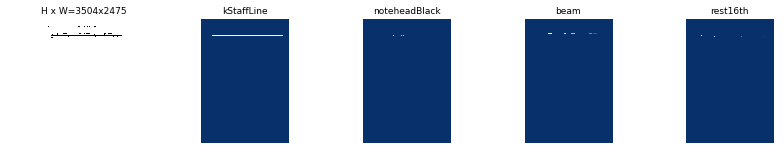

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

In [12]:
# MODEL_DIR = '/import/c4dm-05/elona/maskrcnn-logs/logs_all_layers_101'
MODEL_DIR = '/import/c4dm-05/elona/maskrcnn-logs/1685_dataset_resnet101_20210901'

class InferenceConfig(DoremiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights from  /import/c4dm-05/elona/maskrcnn-logs/1685_dataset_resnet101_20210901/doremi20210504T1930/mask_rcnn_doremi_0079.h5
Re-starting from epoch 79


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (84,)                 min:    0.00000  max: 3504.00000  float64
gt_class_id              shape: (65,)                 min:   19.00000  max:   56.00000  int32
gt_bbox                  shape: (65, 4)               min:  116.00000  max:  822.00000  int32
gt_mask                  shape: (1024, 1024, 65)      min:    0.00000  max:    1.00000  bool


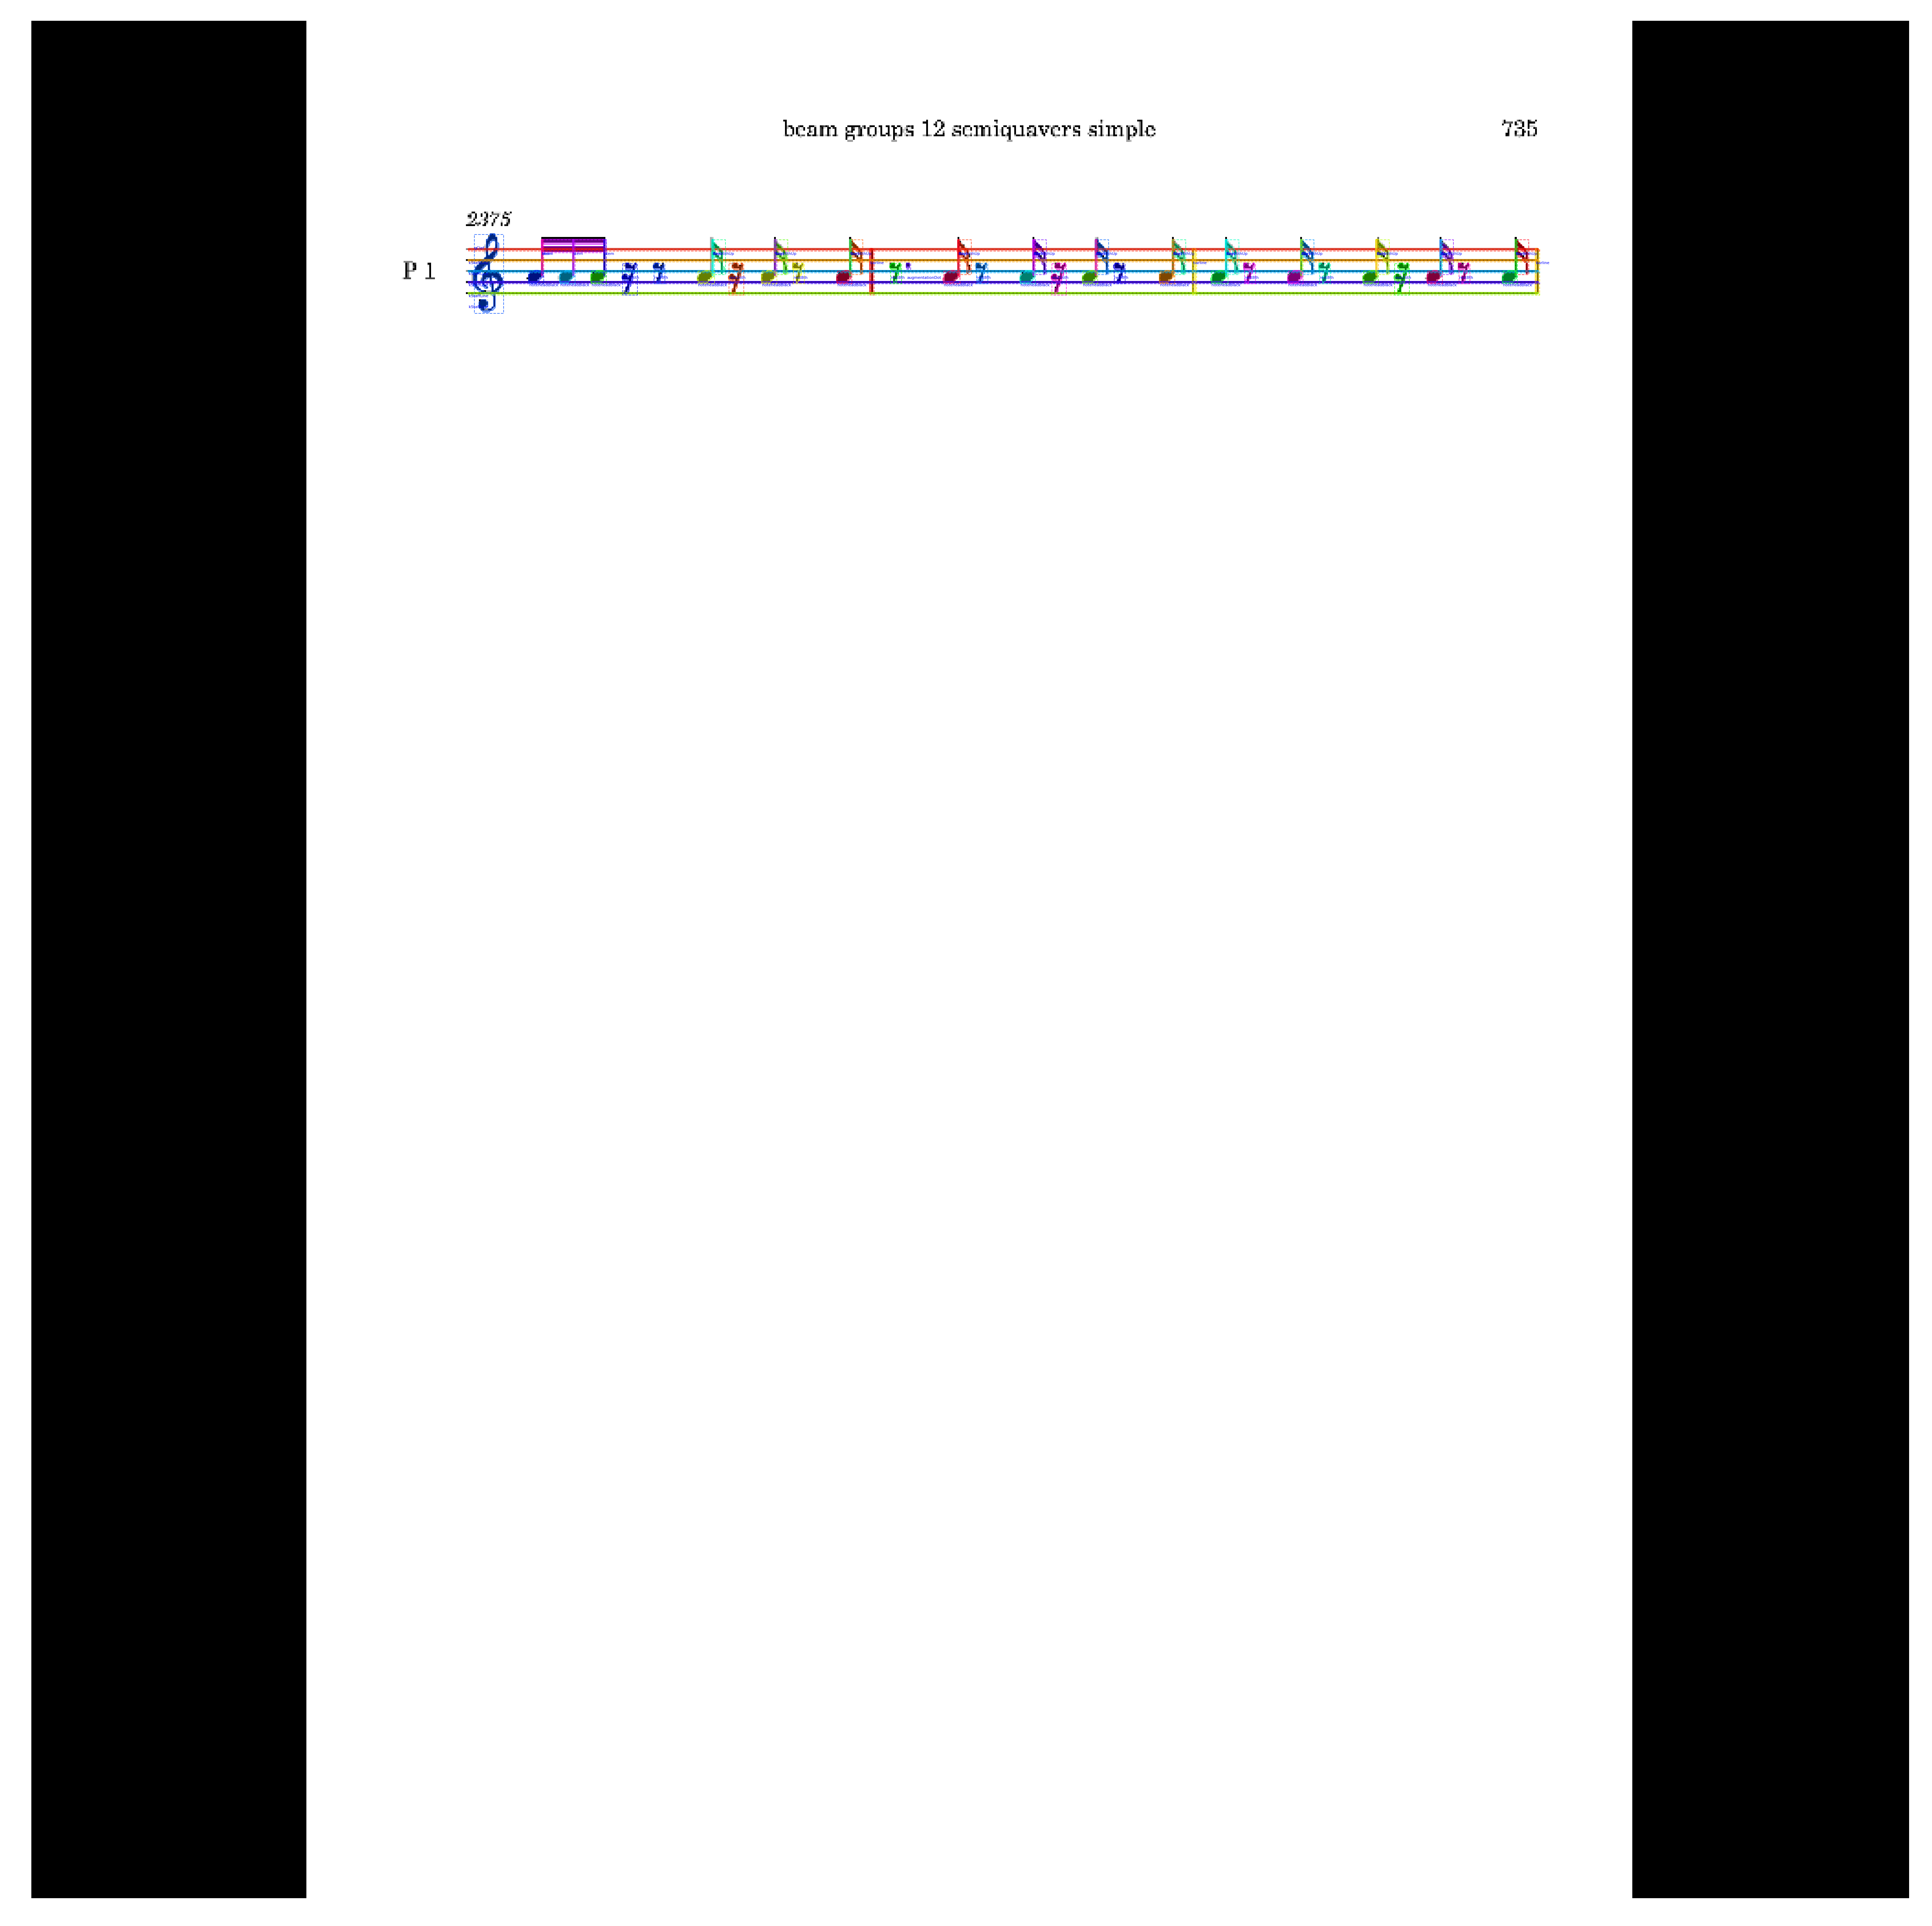

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(100, 100))

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (84,)                 min:    0.00000  max: 3504.00000  float64
class_ids                shape: (97,)                 min:    4.00000  max:   56.00000  int32
bbox                     shape: (97, 4)               min:   85.00000  max:  822.00000  int32
mask                     shape: (1024, 1024, 97)      min:    0.00000  max:    1.00000  bool


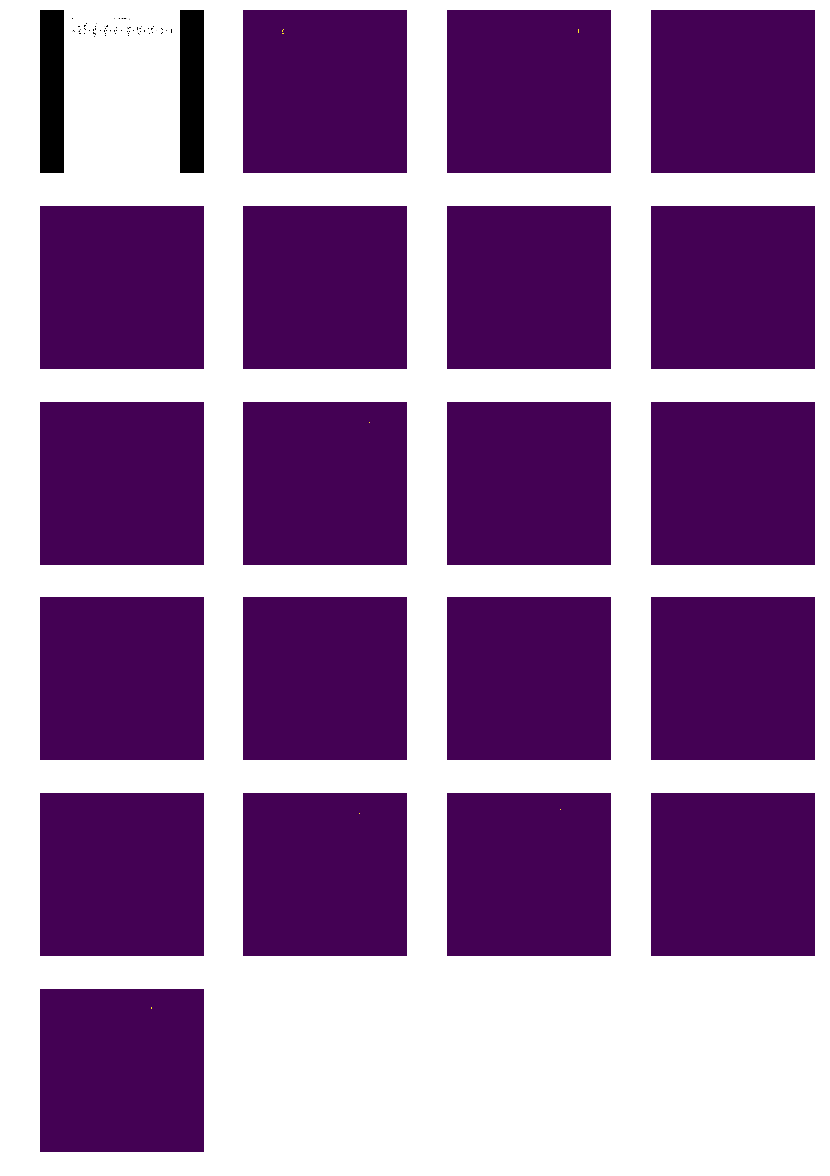

In [14]:
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, inference_config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 20))])

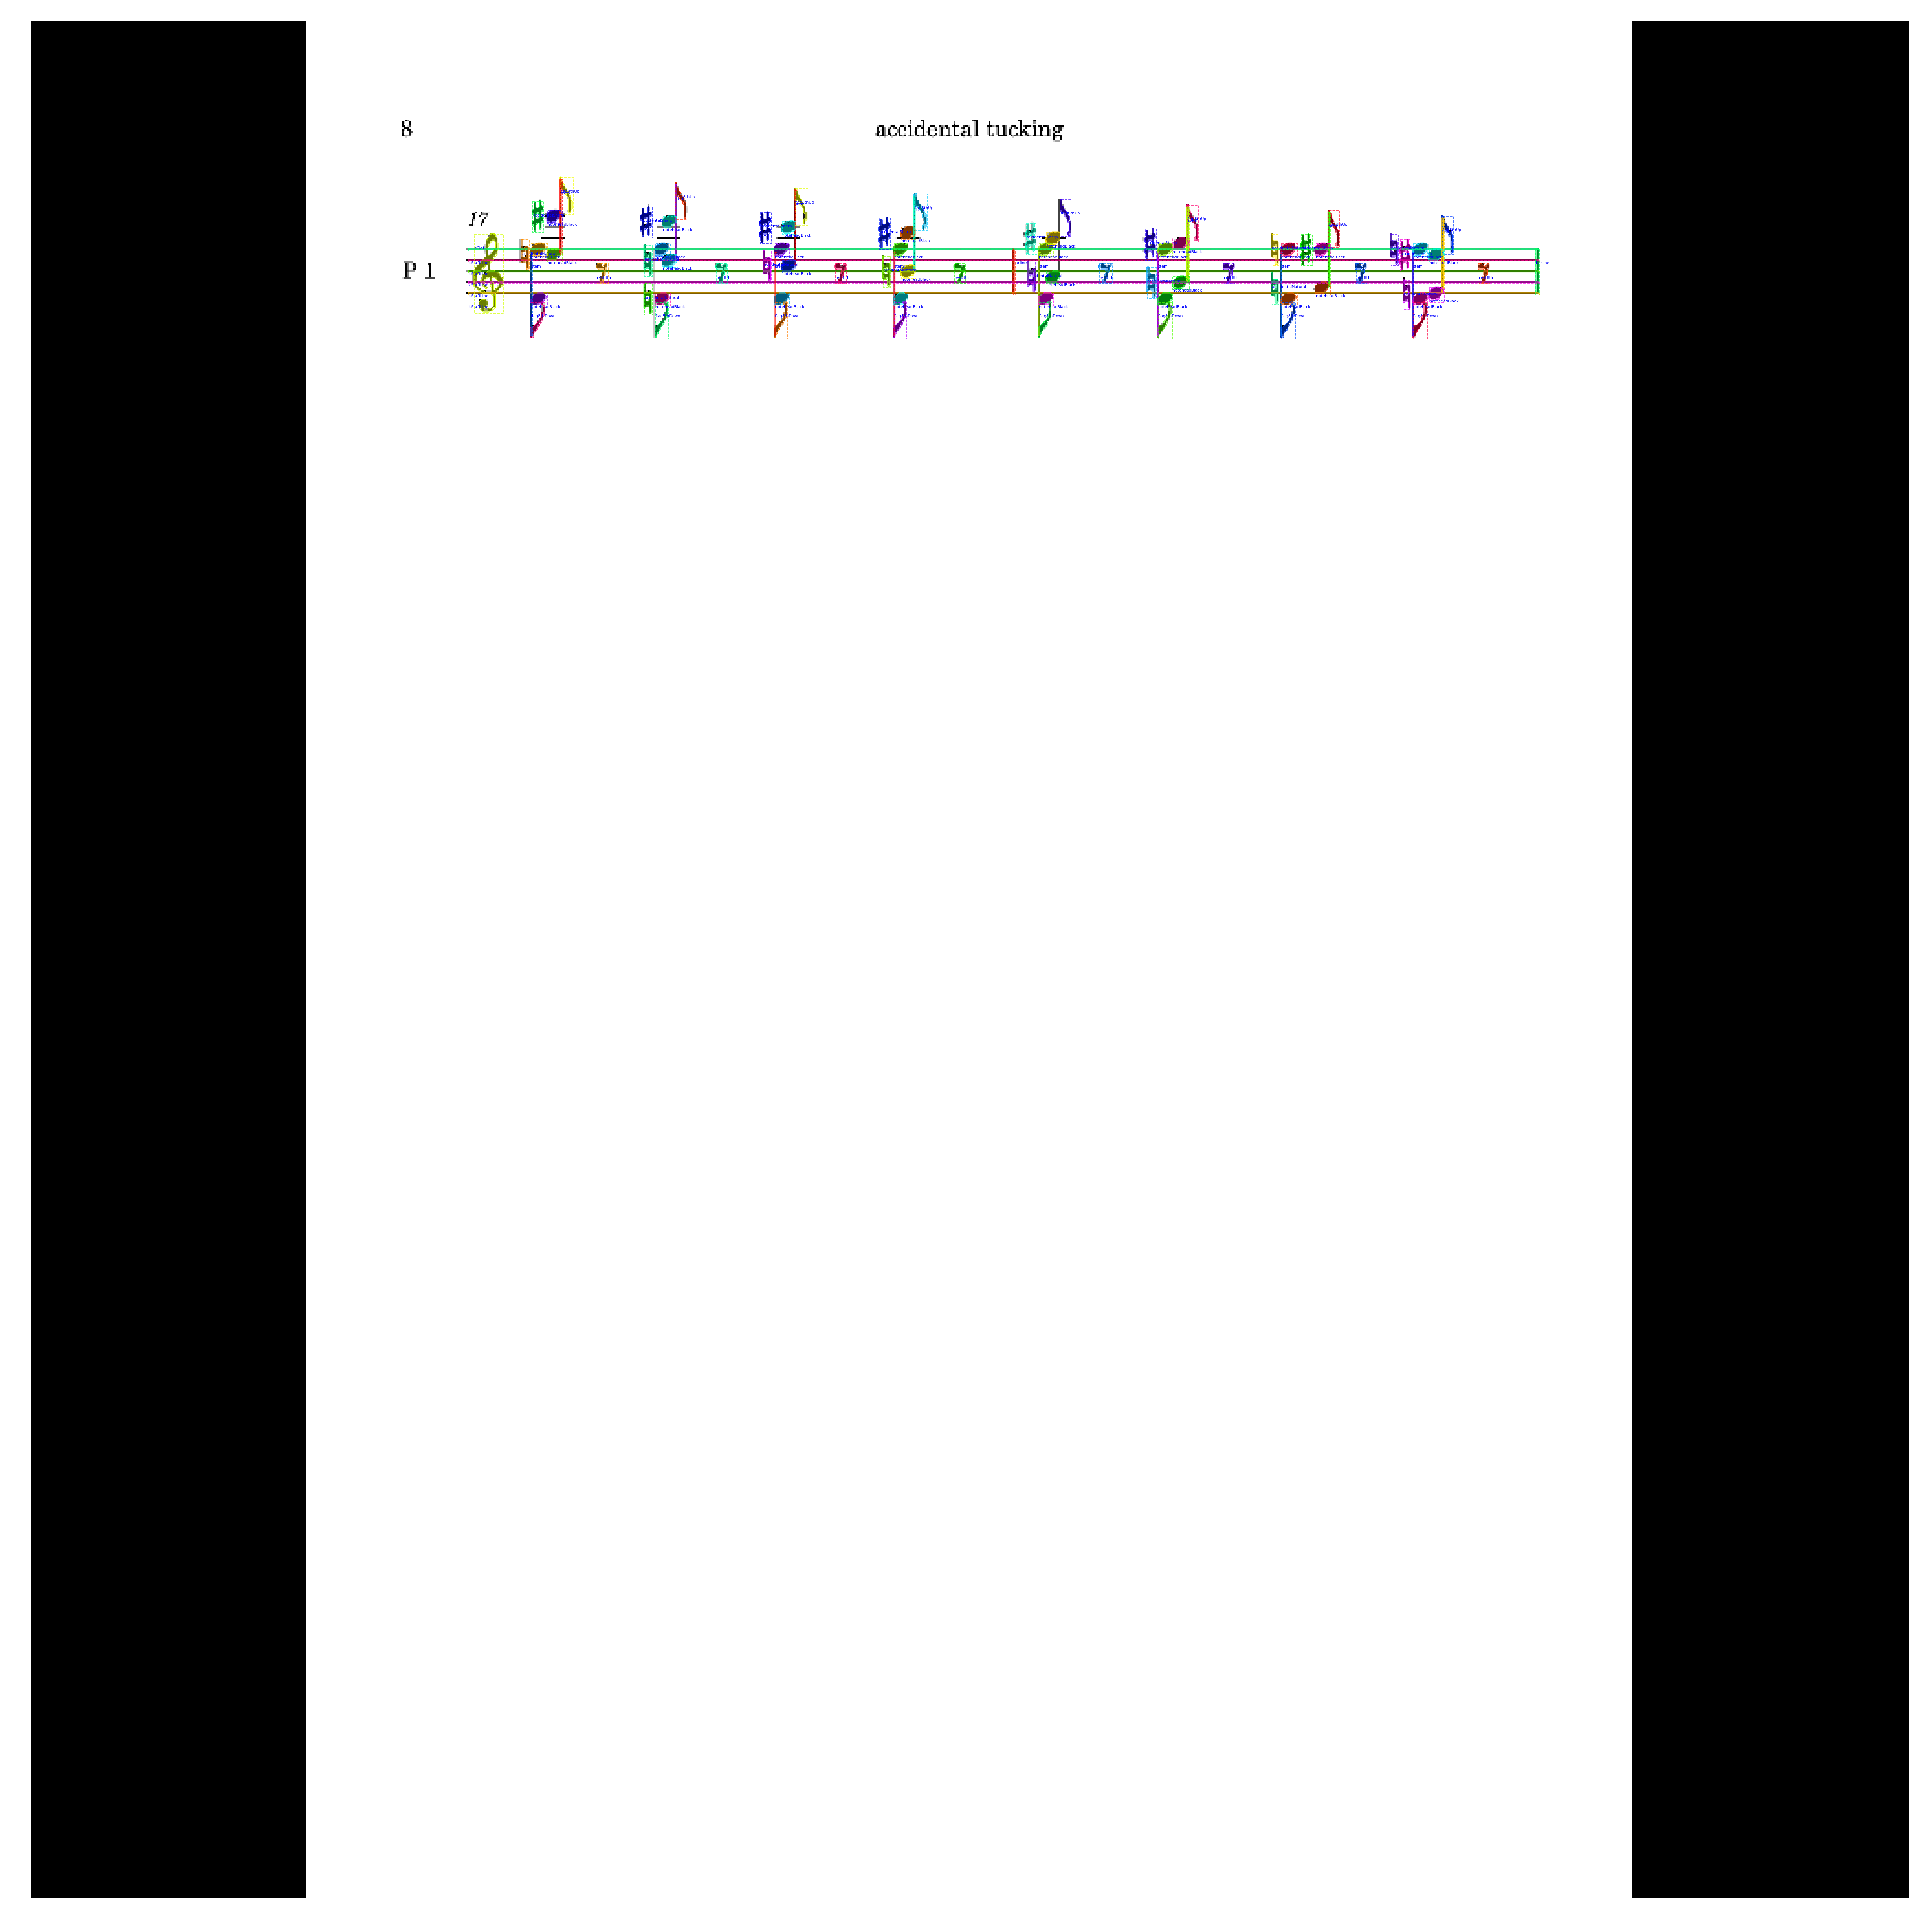

In [15]:
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names,  figsize=(100, 100))

mask                     shape: (56, 56, 97)          min:    0.00000  max:    1.00000  bool


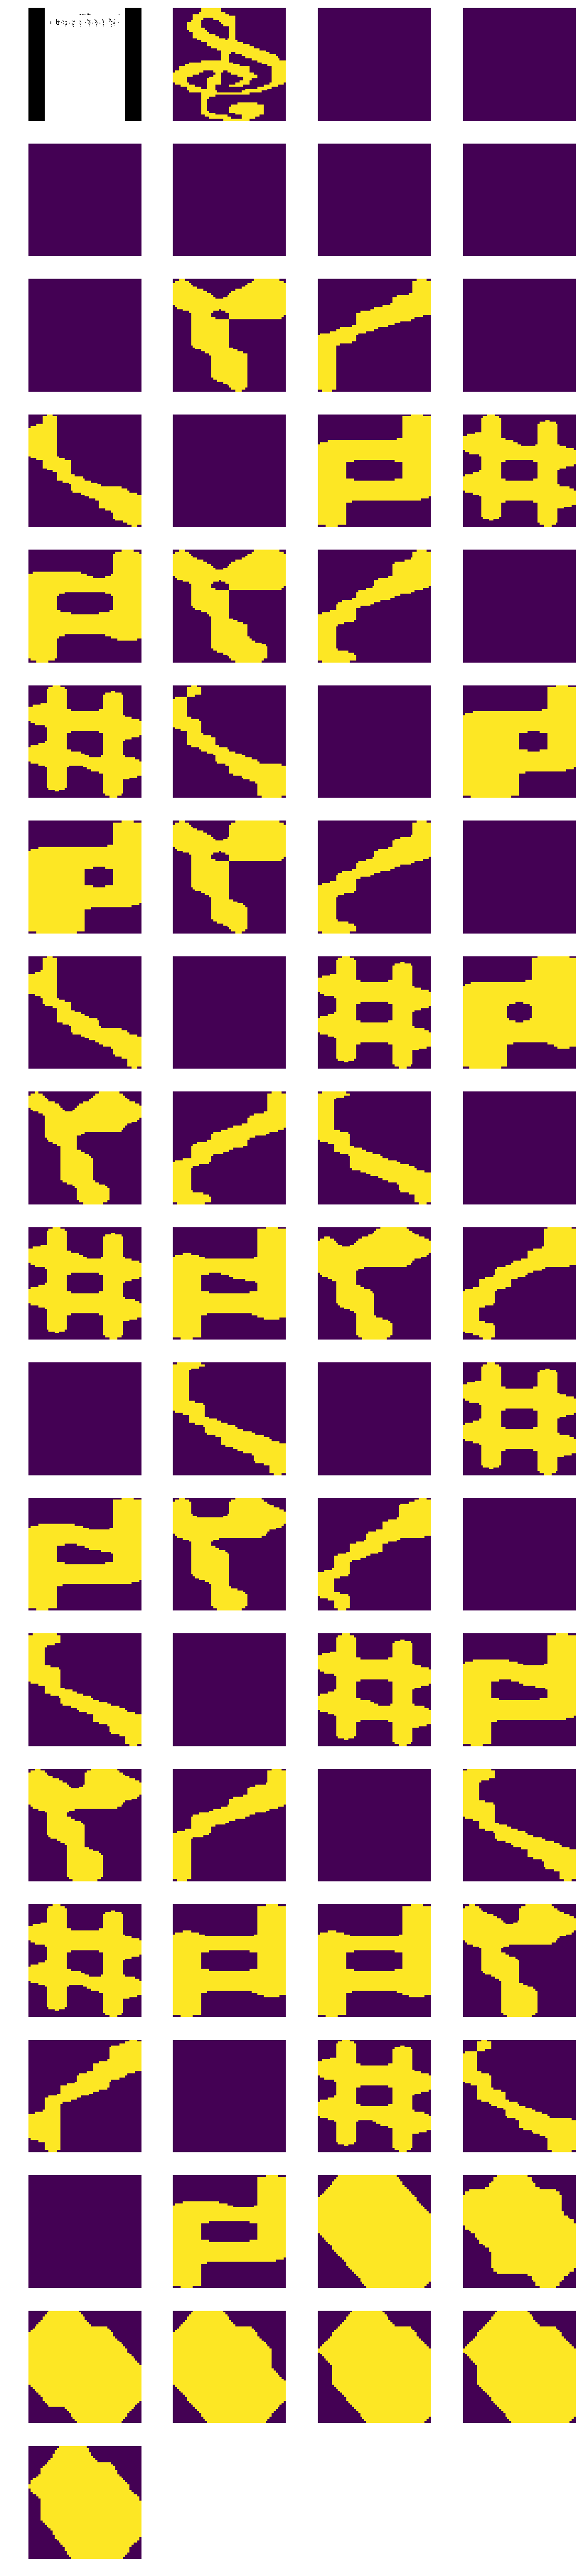

In [16]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, inference_config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 72))])

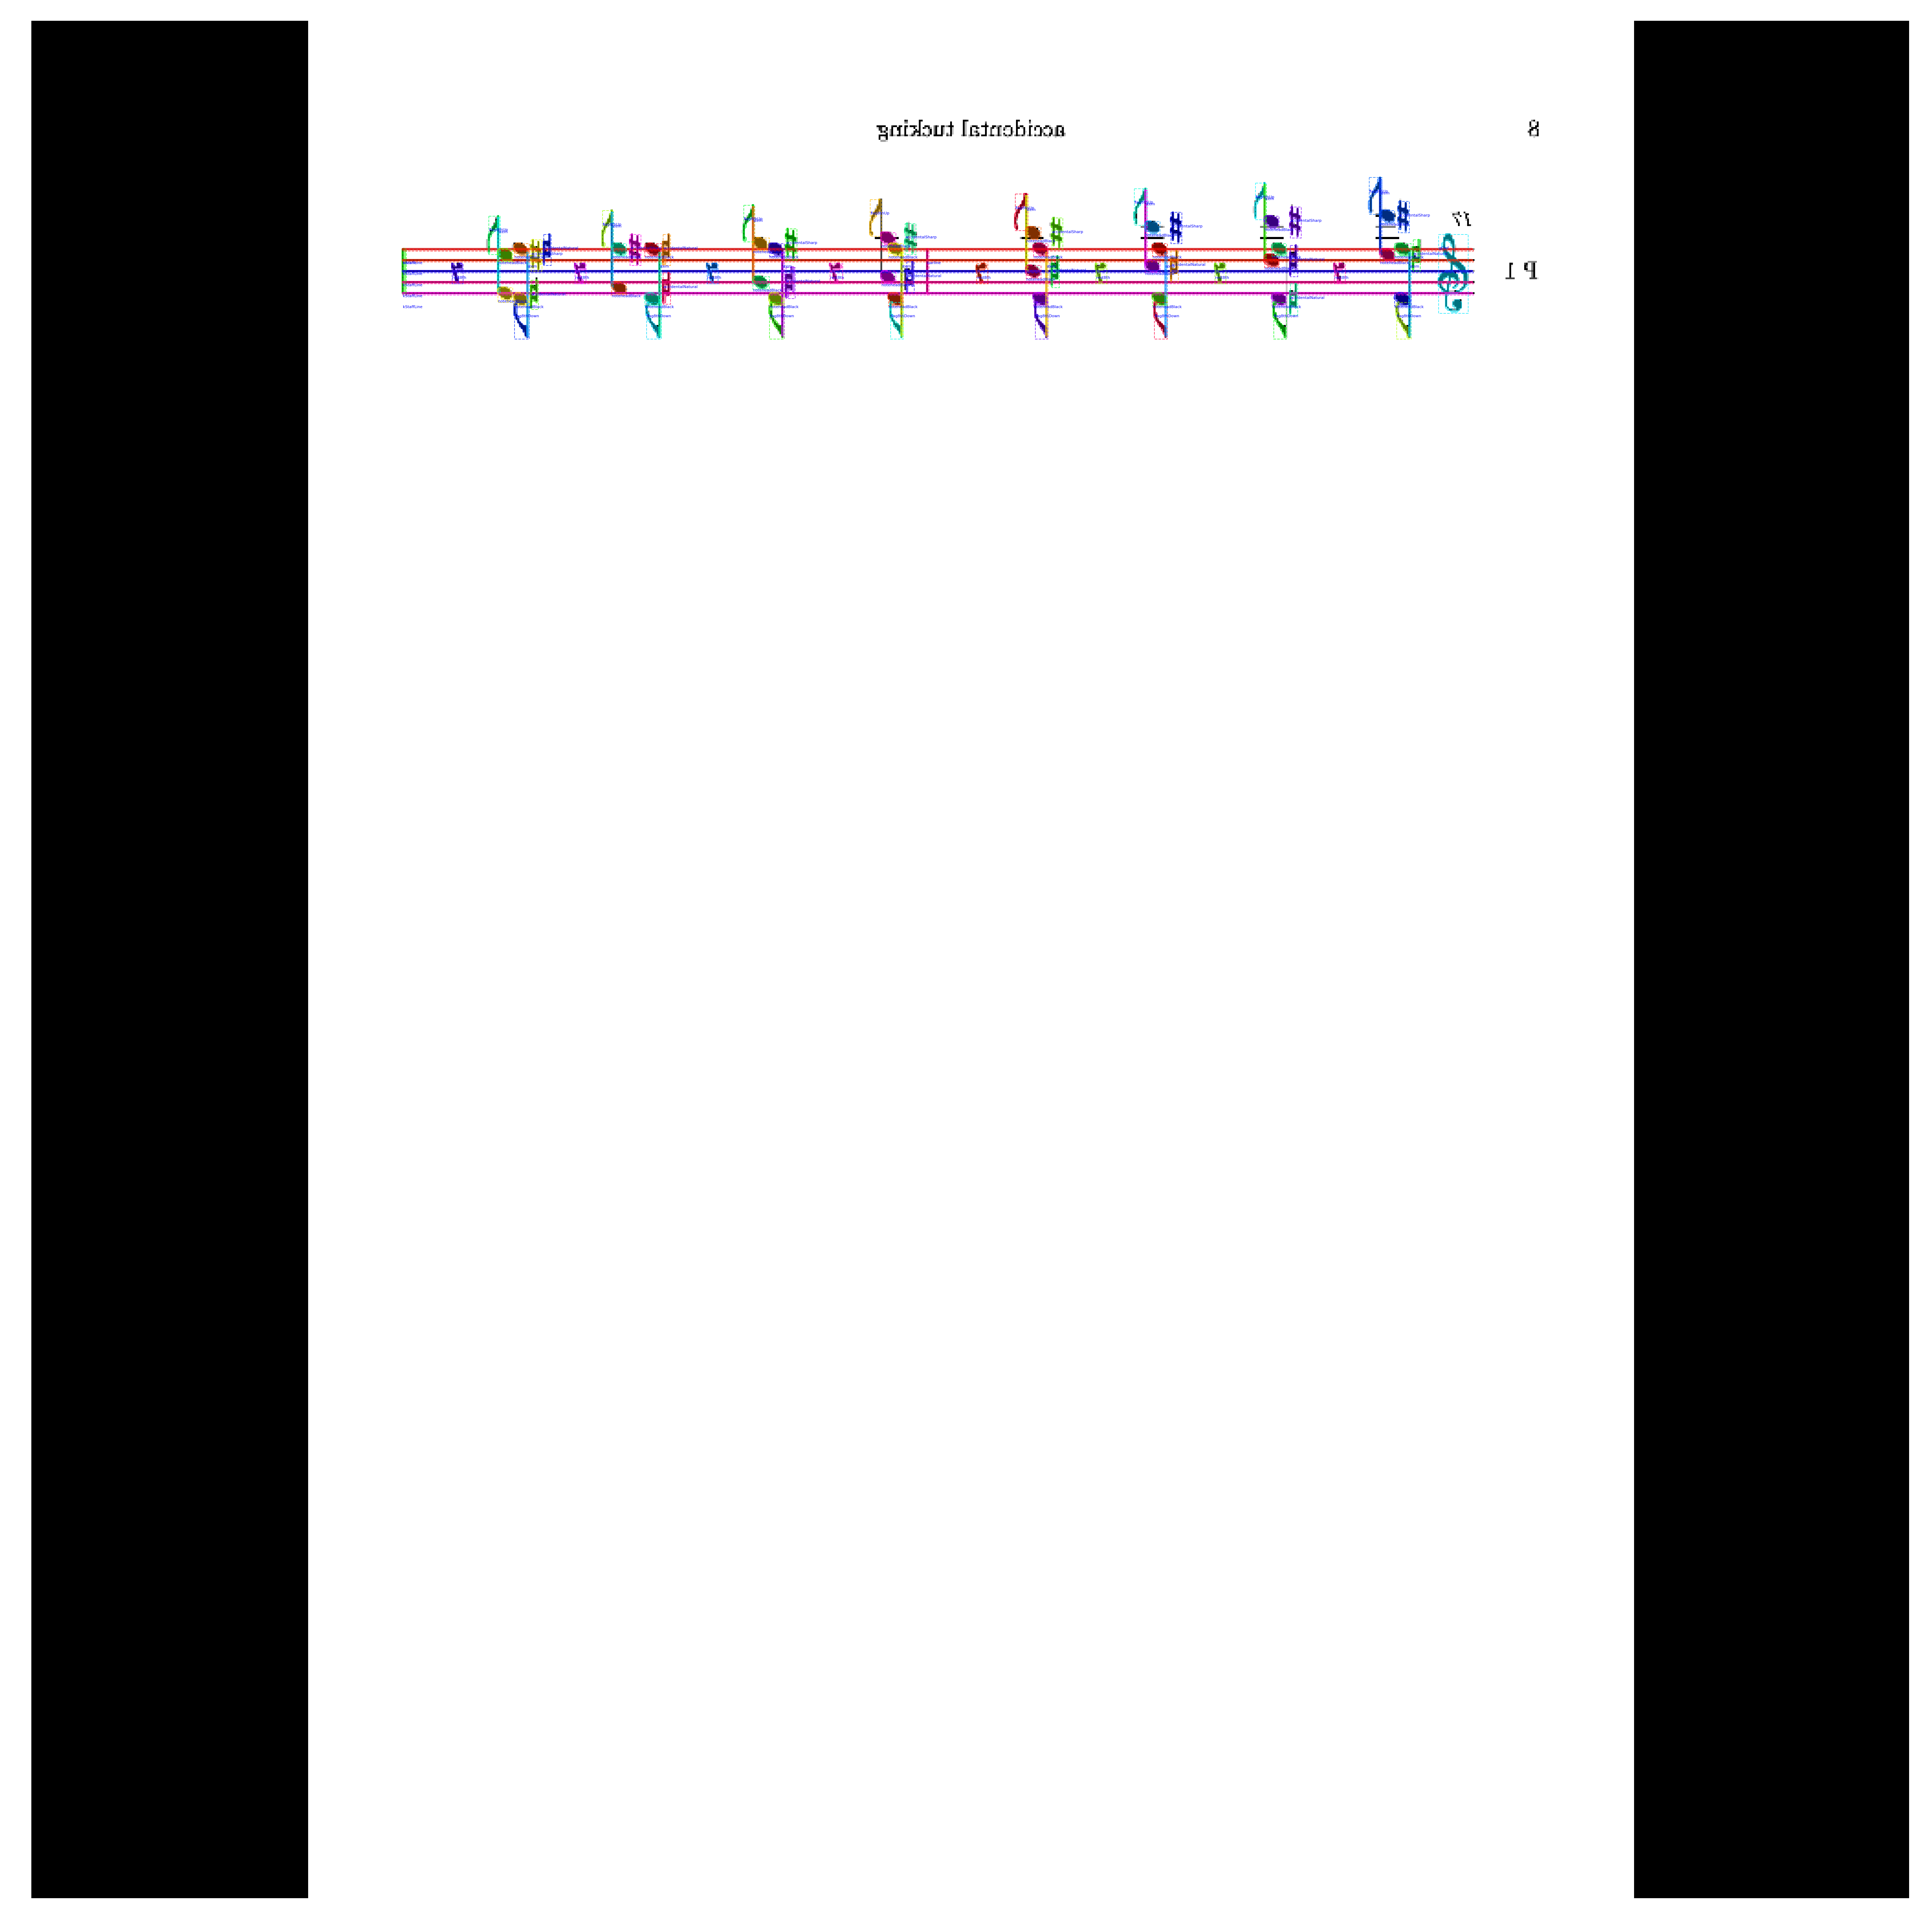

In [17]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names,  figsize=(100, 100))

In [18]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(DoremiConfig, DoremiConfig.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(DoremiConfig.RPN_ANCHOR_SCALES, 
                                          DoremiConfig.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          DoremiConfig.BACKBONE_STRIDES, 
                                          DoremiConfig.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(DoremiConfig.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", DoremiConfig.RPN_ANCHOR_SCALES)
print("ratios: ", DoremiConfig.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // DoremiConfig.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (4, 8, 16, 32, 64)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


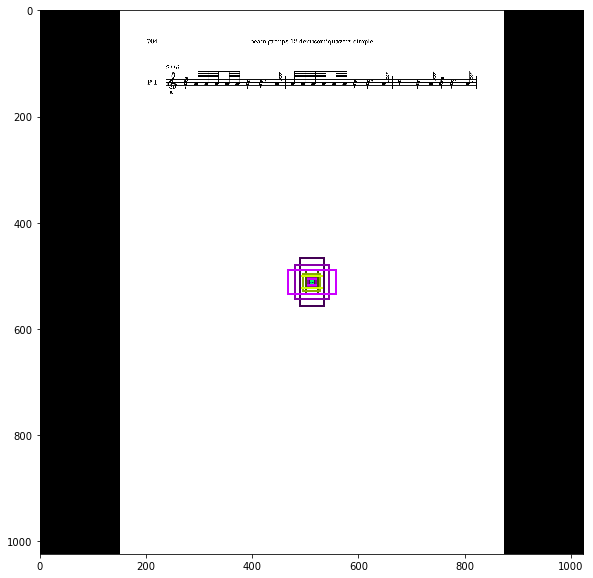

In [19]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_train, DoremiConfig, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / DoremiConfig.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / DoremiConfig.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

Data Generator

In [20]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset_train, DoremiConfig, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [21]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset_train.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    1.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:   58.00000  int32
mrcnn_bbox               shape: (4, 200, 72, 4)       min:   -4.11765  max:    4.25000  float32
mrcnn_mask               shape: (4, 200, 28, 28, 72)  min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:   58.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  822.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 512, 4)           min:  -36.23922  max:   30.93592  float64
image_id:  128 /homes/es314/DOREMI_version_2/DOREMI_v3/images/syncopation 1b-021.png


anchors                  shape: (261888, 4)           min:  -45.25483  max: 1022.82843  float64
refined_anchors          shape: (133, 4)              min:  115.99998  max:  822.00000  float32
Positive anchors: 133
Negative anchors: 379
Neutral anchors: 261376
BG                     : 134
gClef                  : 1
kStaffLine             : 10
noteheadBlack          : 5
stem                   : 46
tie                    : 4


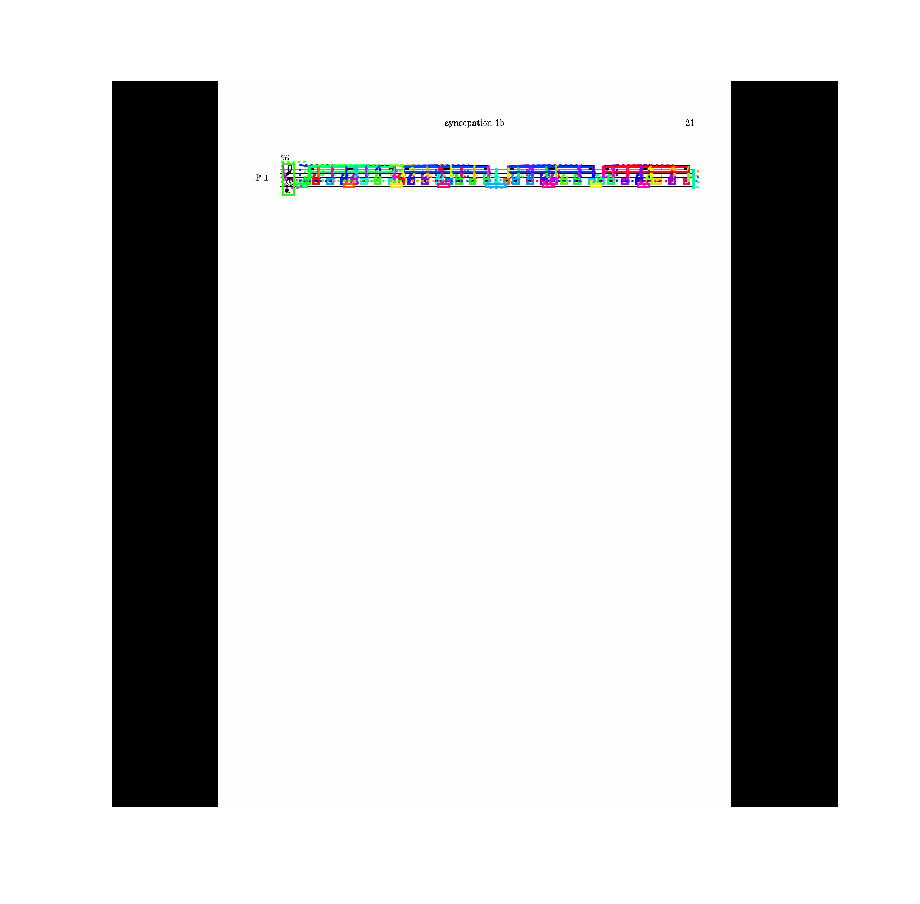

In [23]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], DoremiConfig)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * DoremiConfig.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset_train.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors,  figsize=(100, 100), ax=ax)

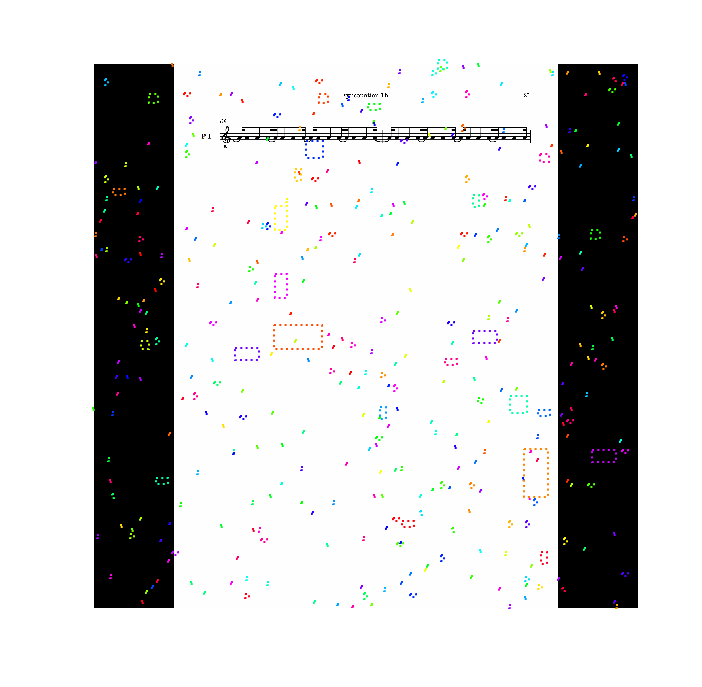

In [24]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

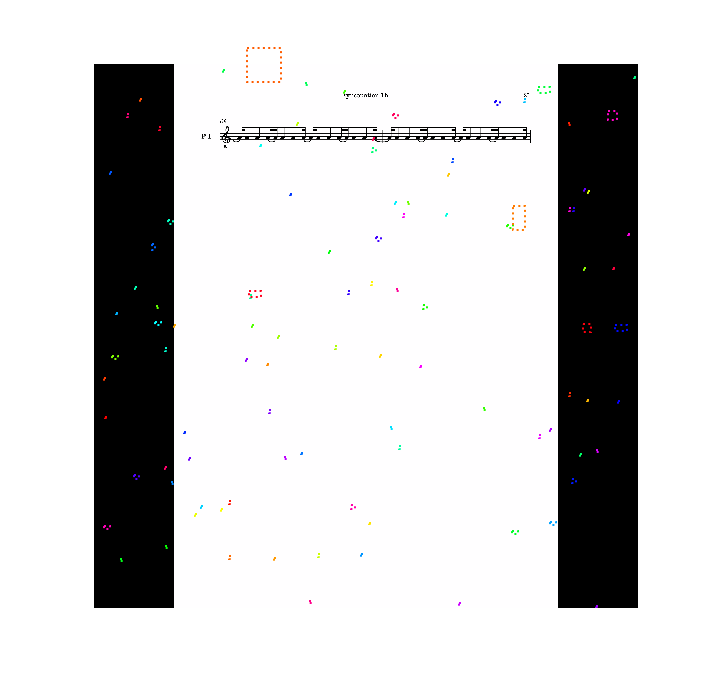

In [26]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

# ROI

Positive ROIs:  66
Negative ROIs:  134
Positive Ratio: 0.33
Unique ROIs: 200 out of 200


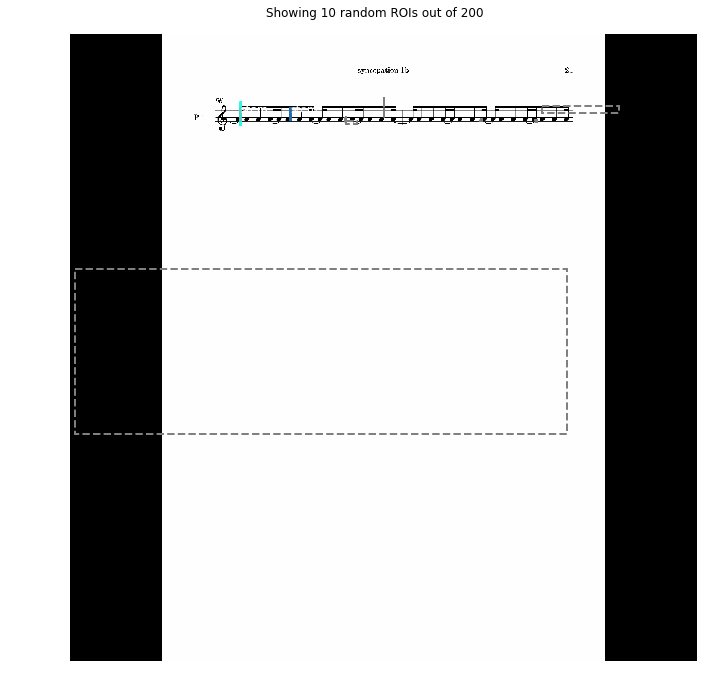

In [27]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * DoremiConfig.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset_train.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

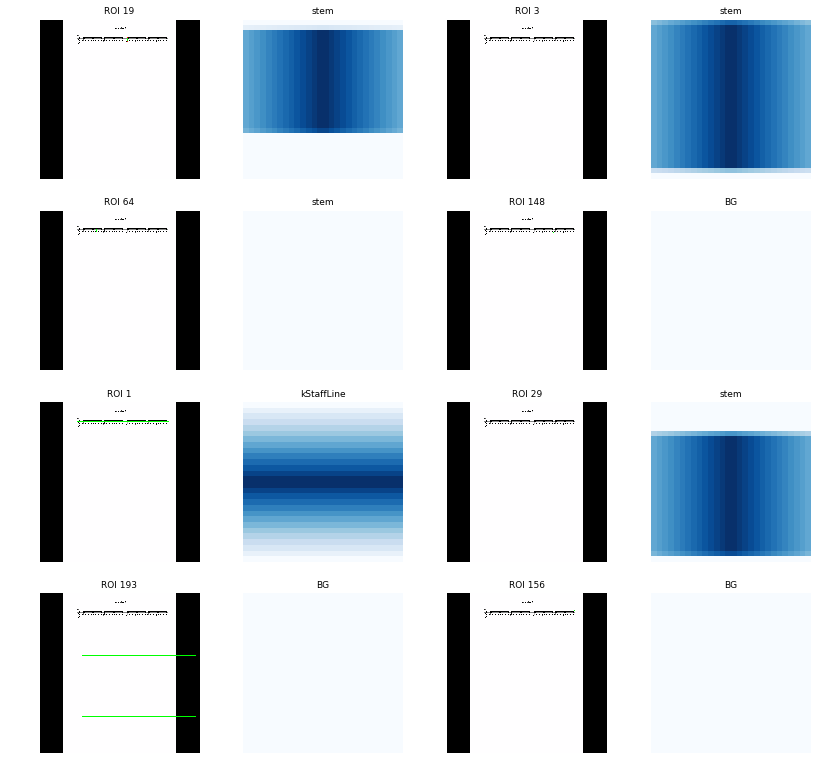

In [29]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset_train.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [30]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset_train, DoremiConfig, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Inspect doremi model

In [31]:
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                84
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0003
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [32]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [33]:
# splash = doremi.color_splash(image, r['masks'])
# display_images([splash], cols=1)



# Step by Step Prediction
## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high objectness score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

## 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [34]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

AttributeError: 'MaskRCNN' object has no attribute 'anchors'

In [35]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

NameError: name 'positive_anchors' is not defined

In [36]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.04424  max:    0.99885  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.10889  max:    0.99996  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    0.99996  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1146.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.05346  max:    0.84911  float32


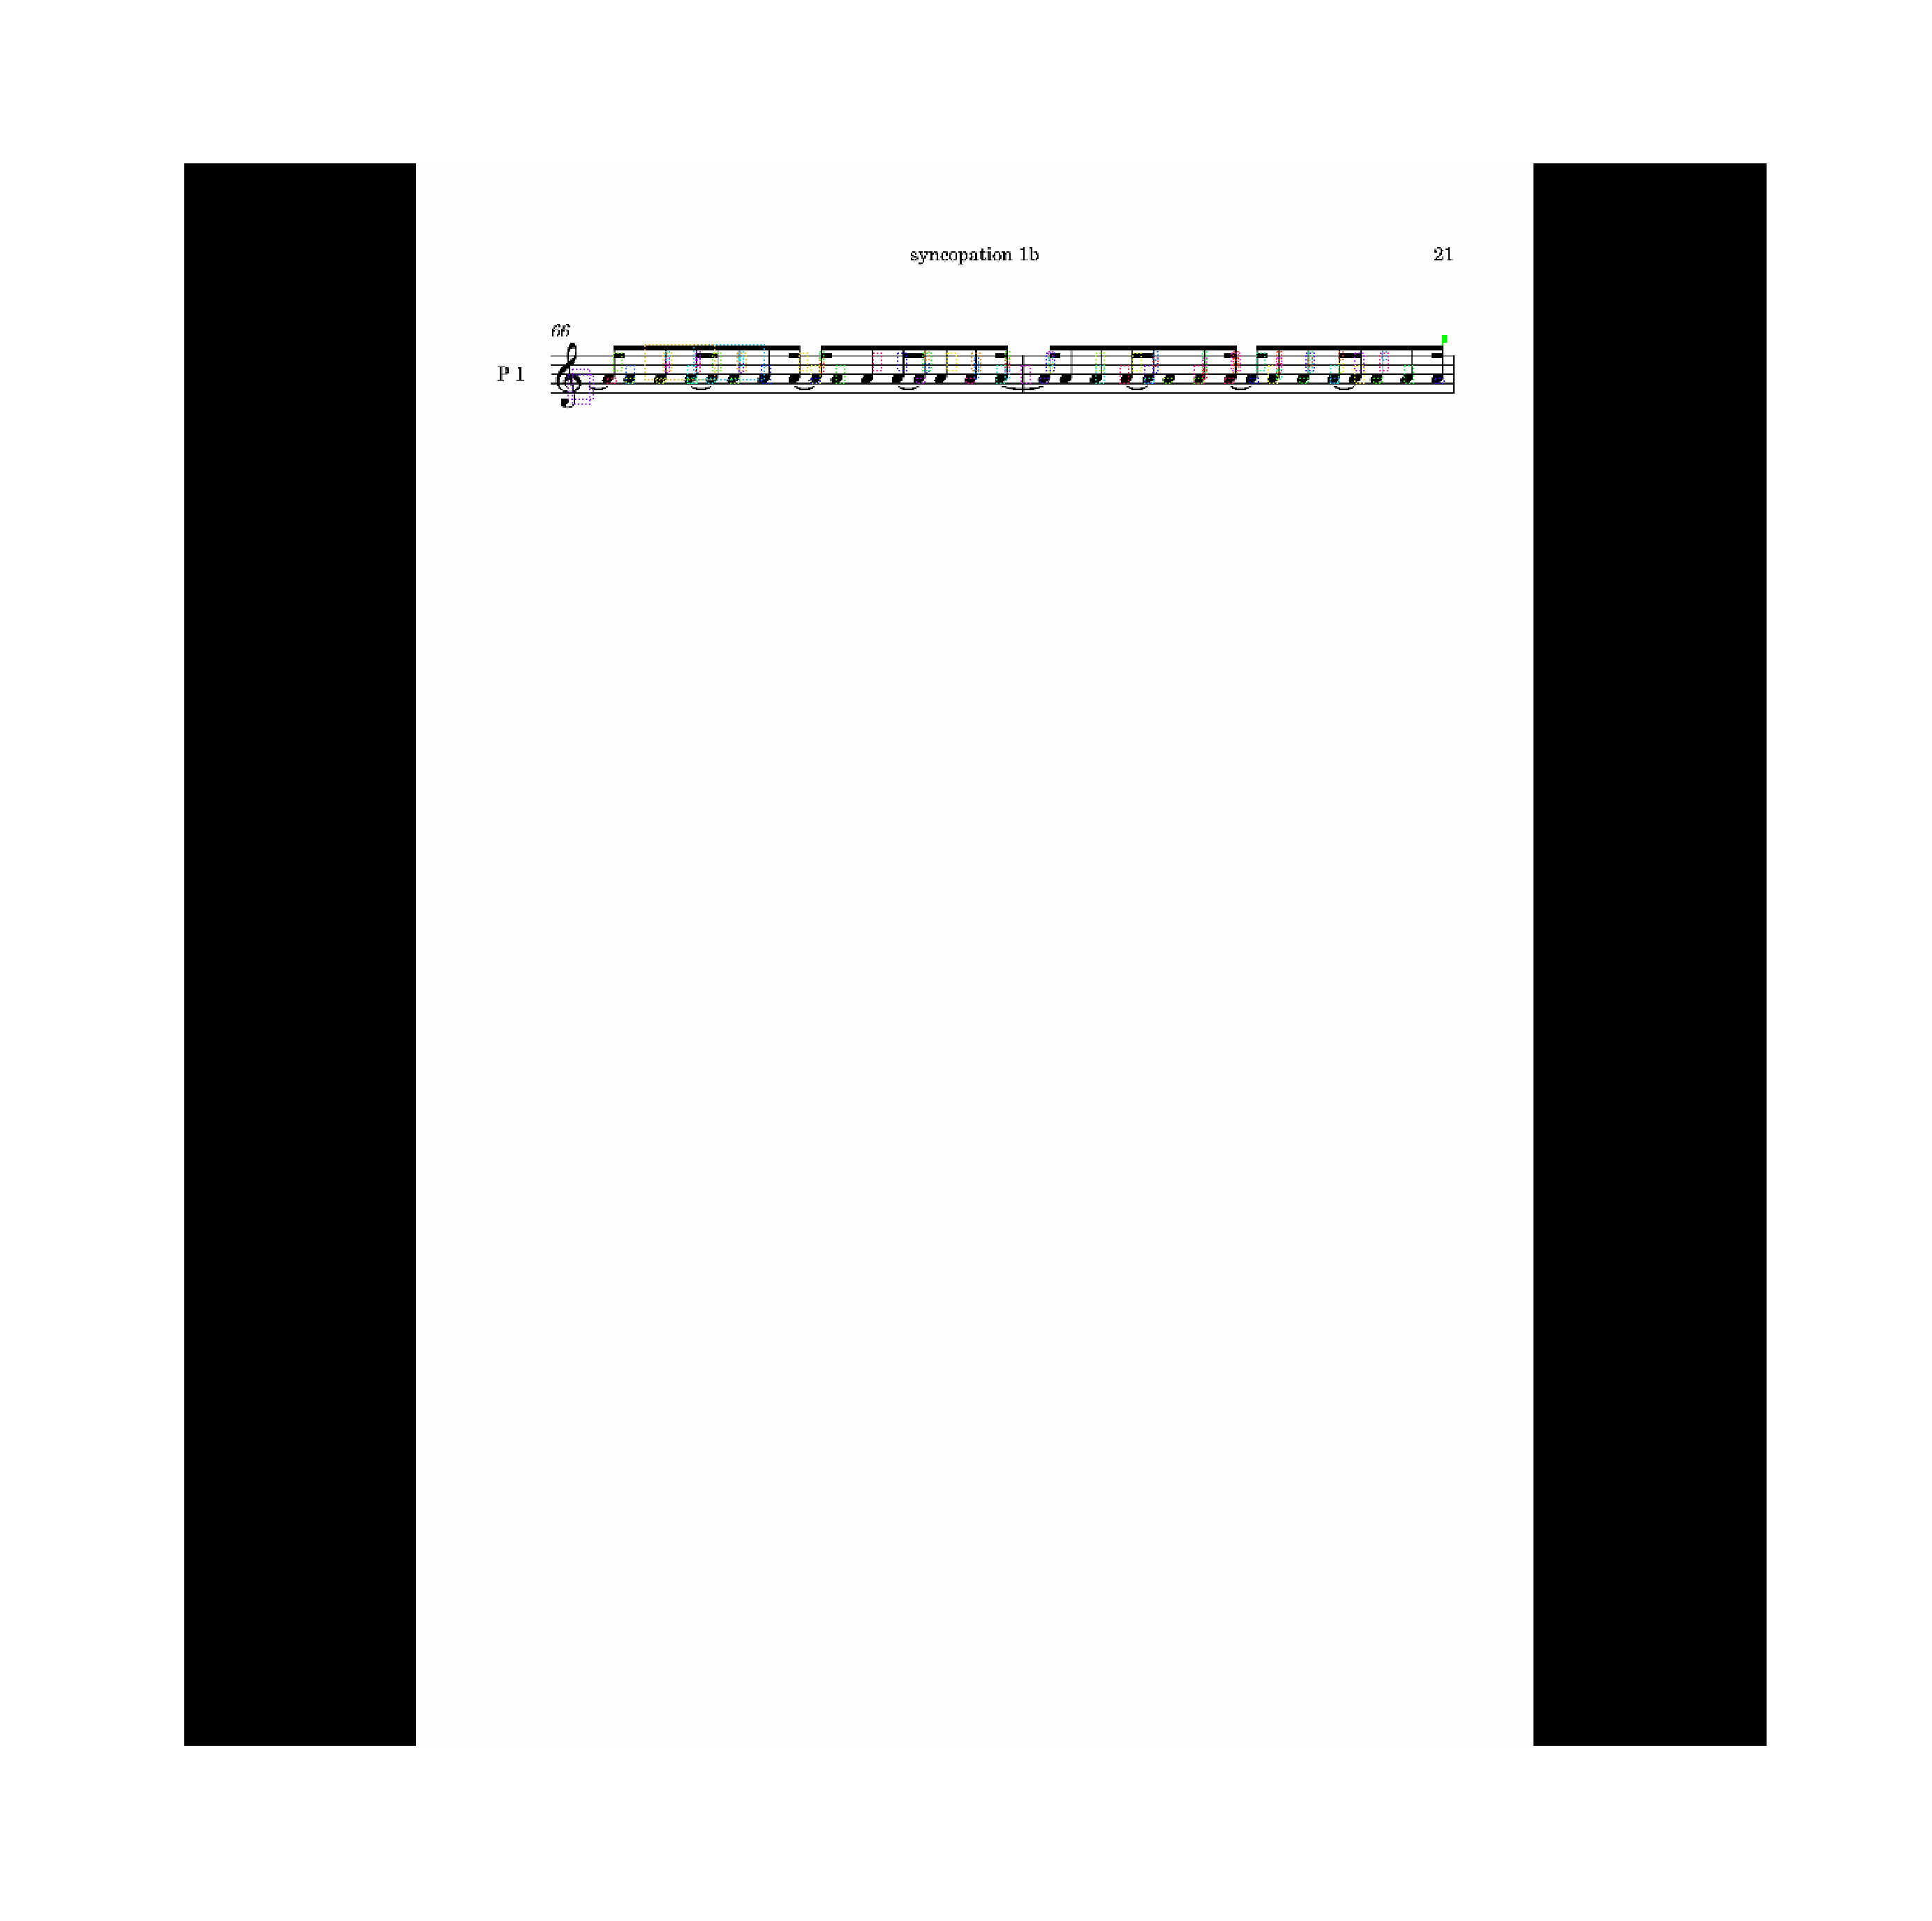

In [37]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

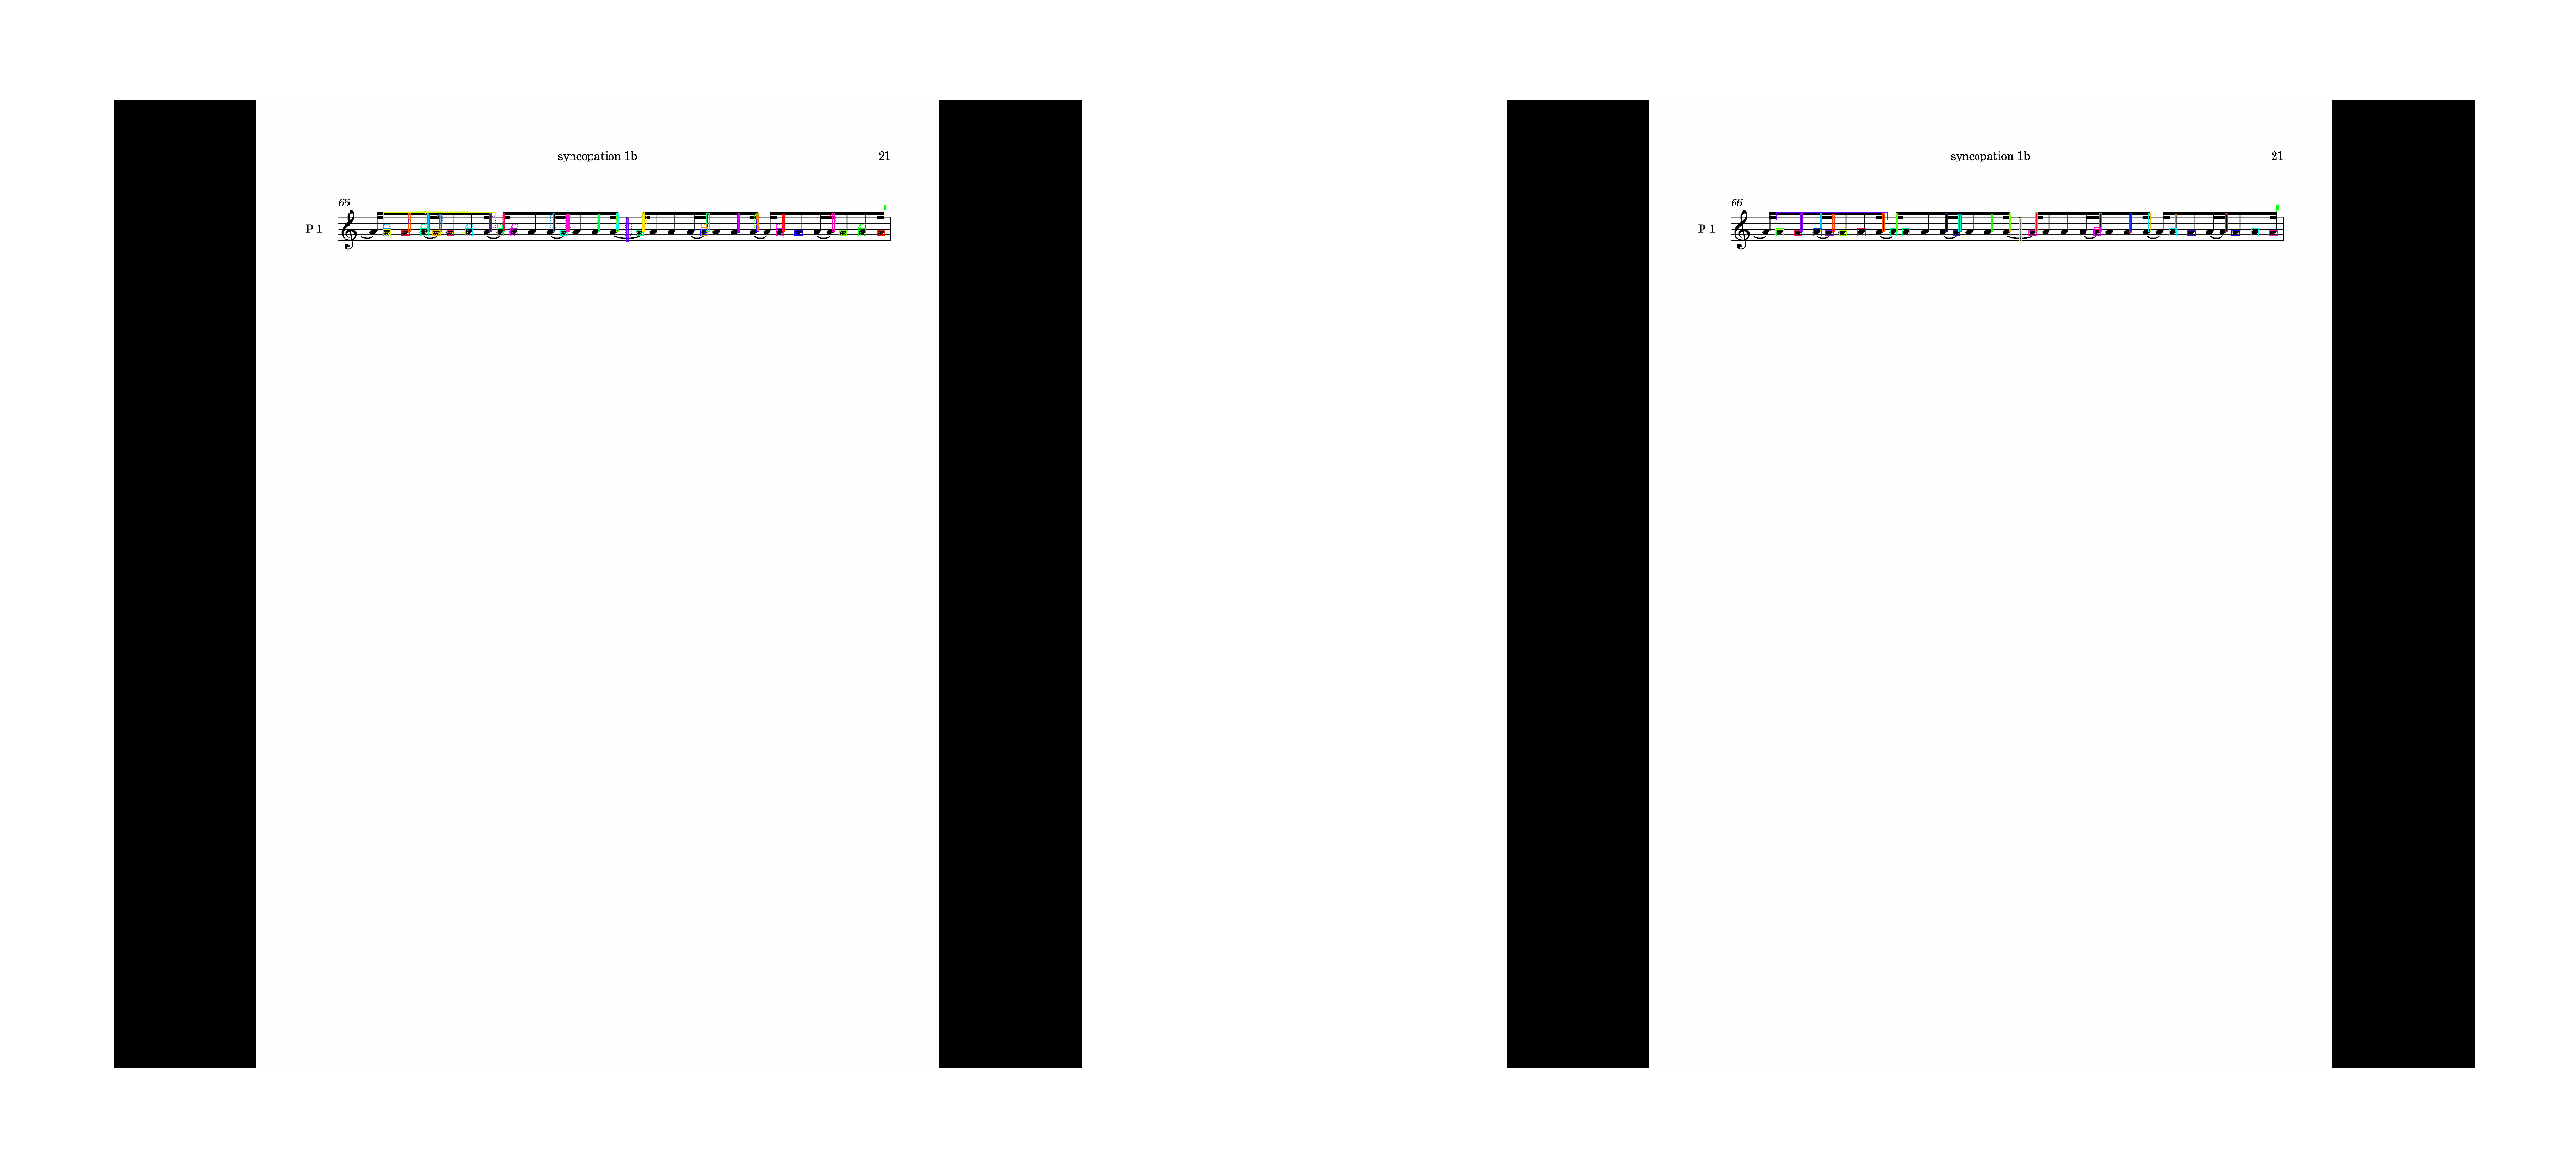

In [38]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

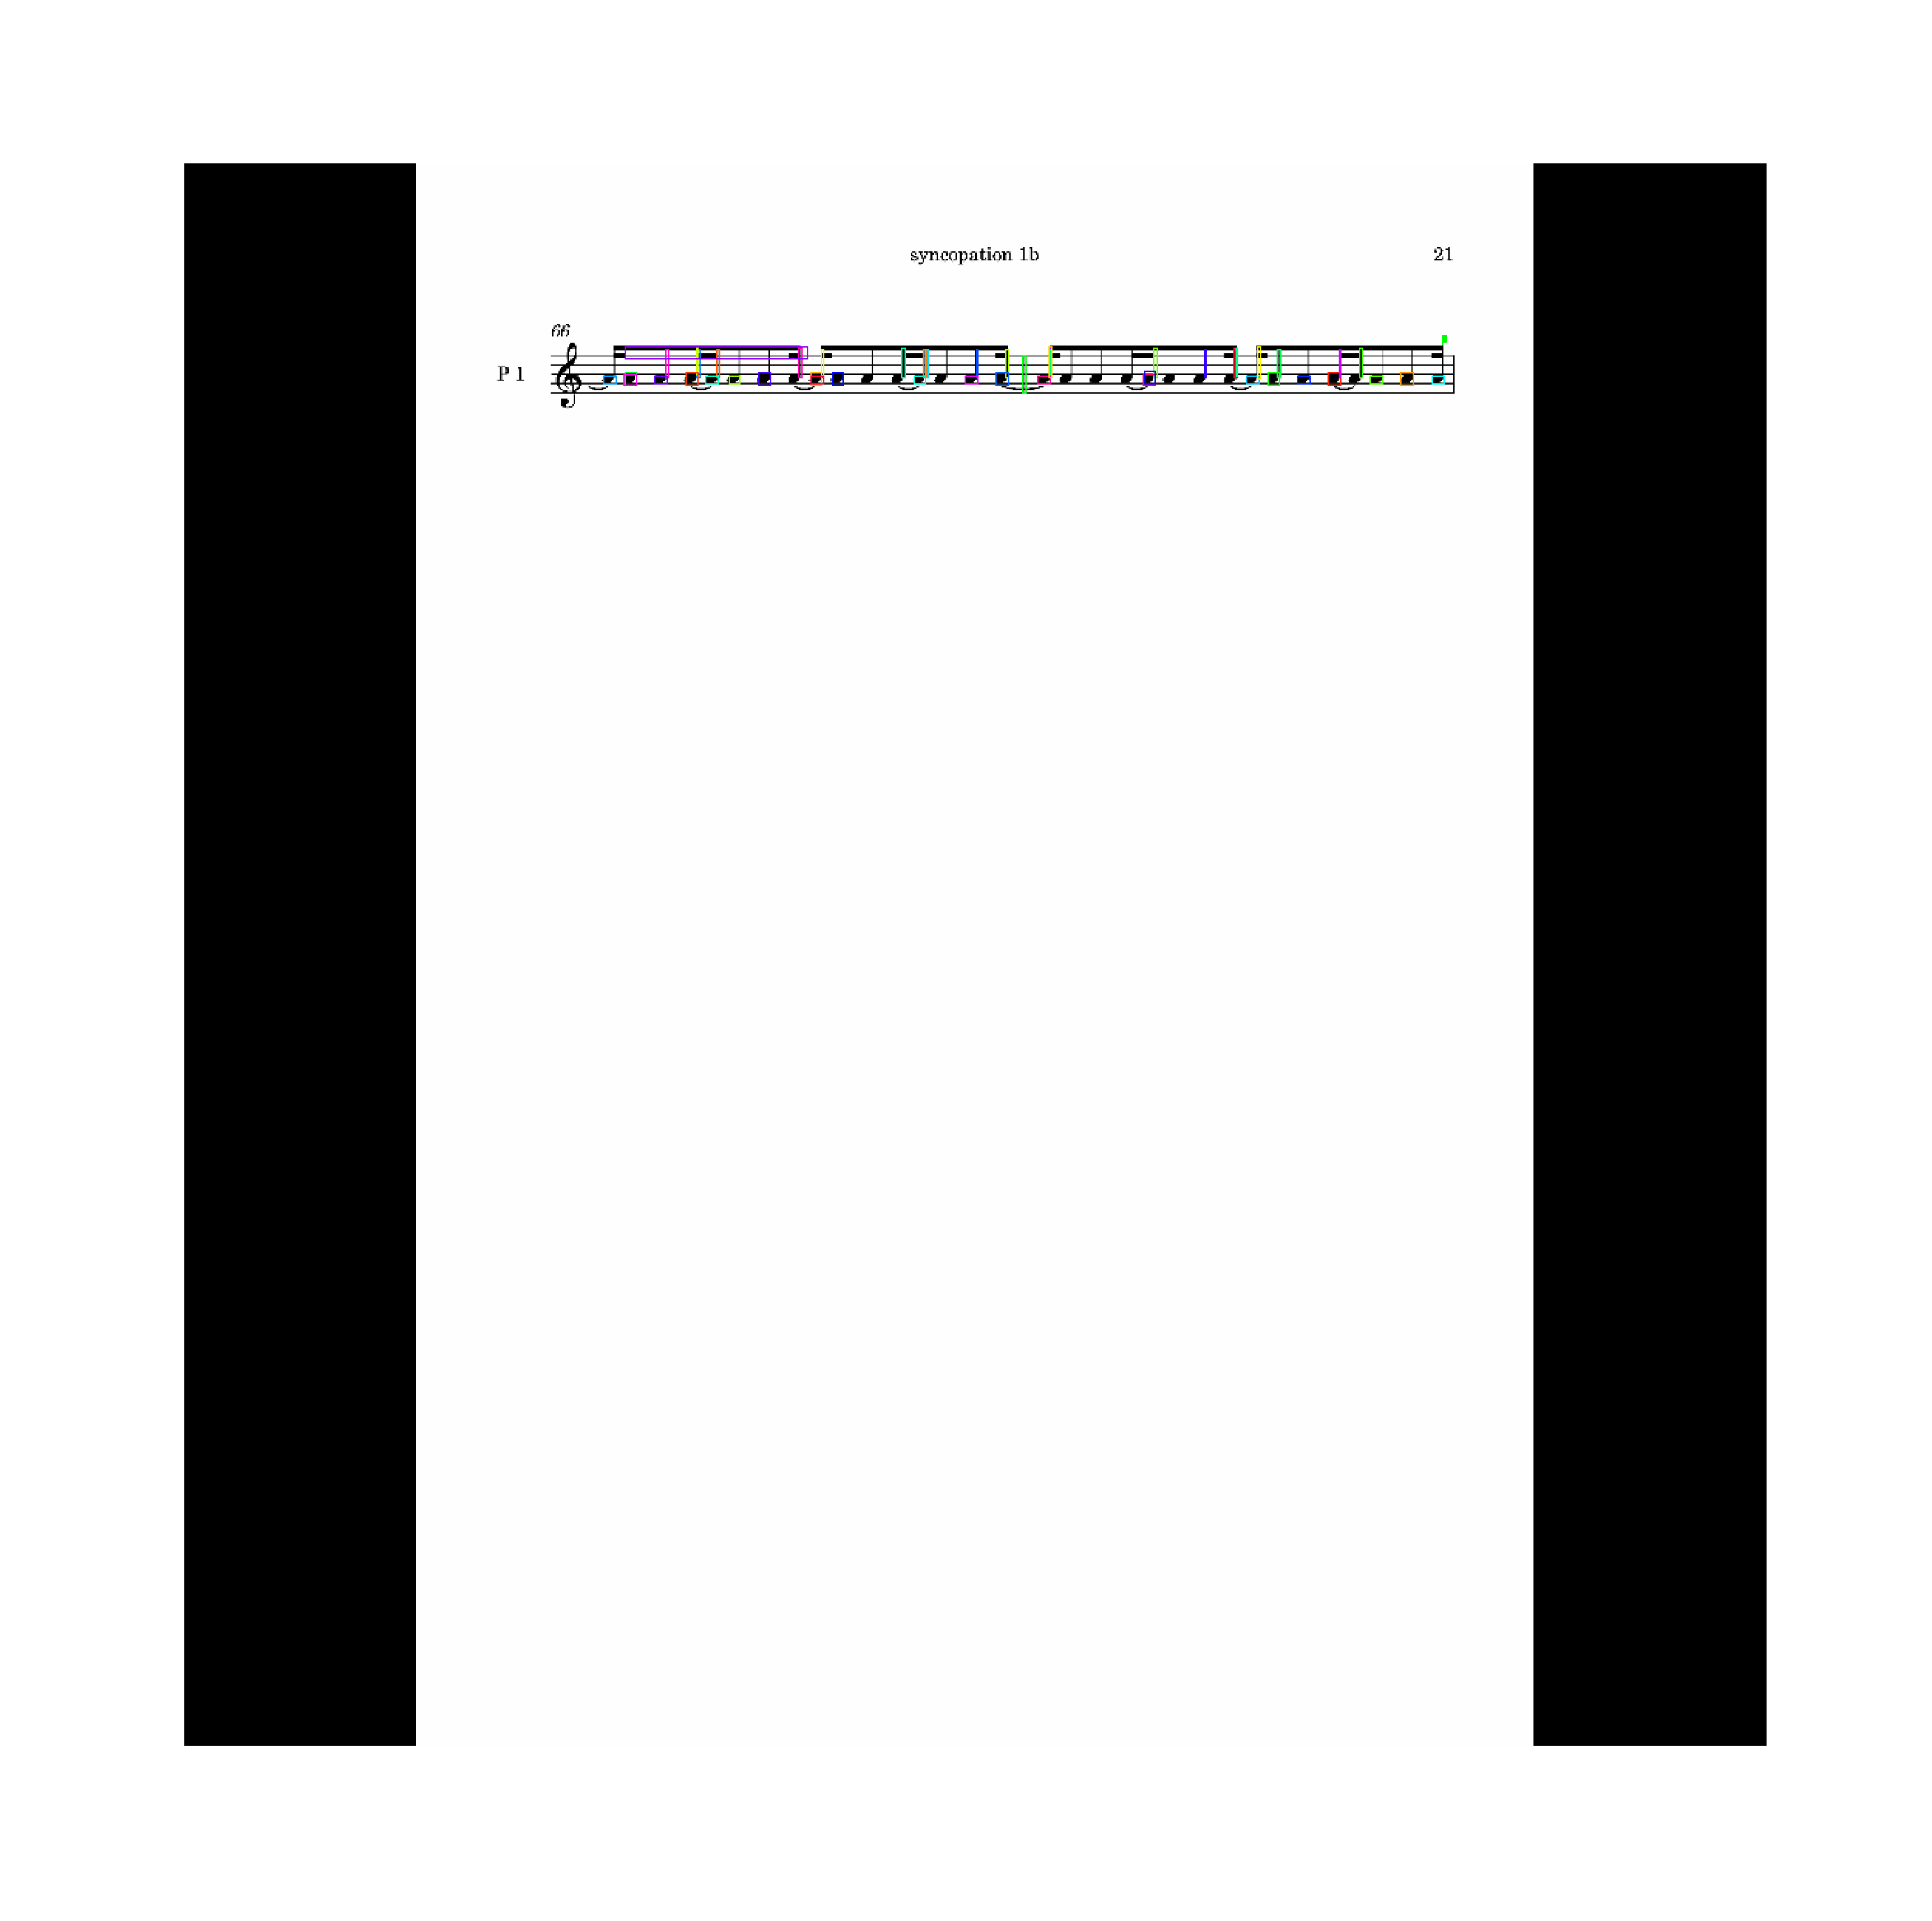

In [39]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

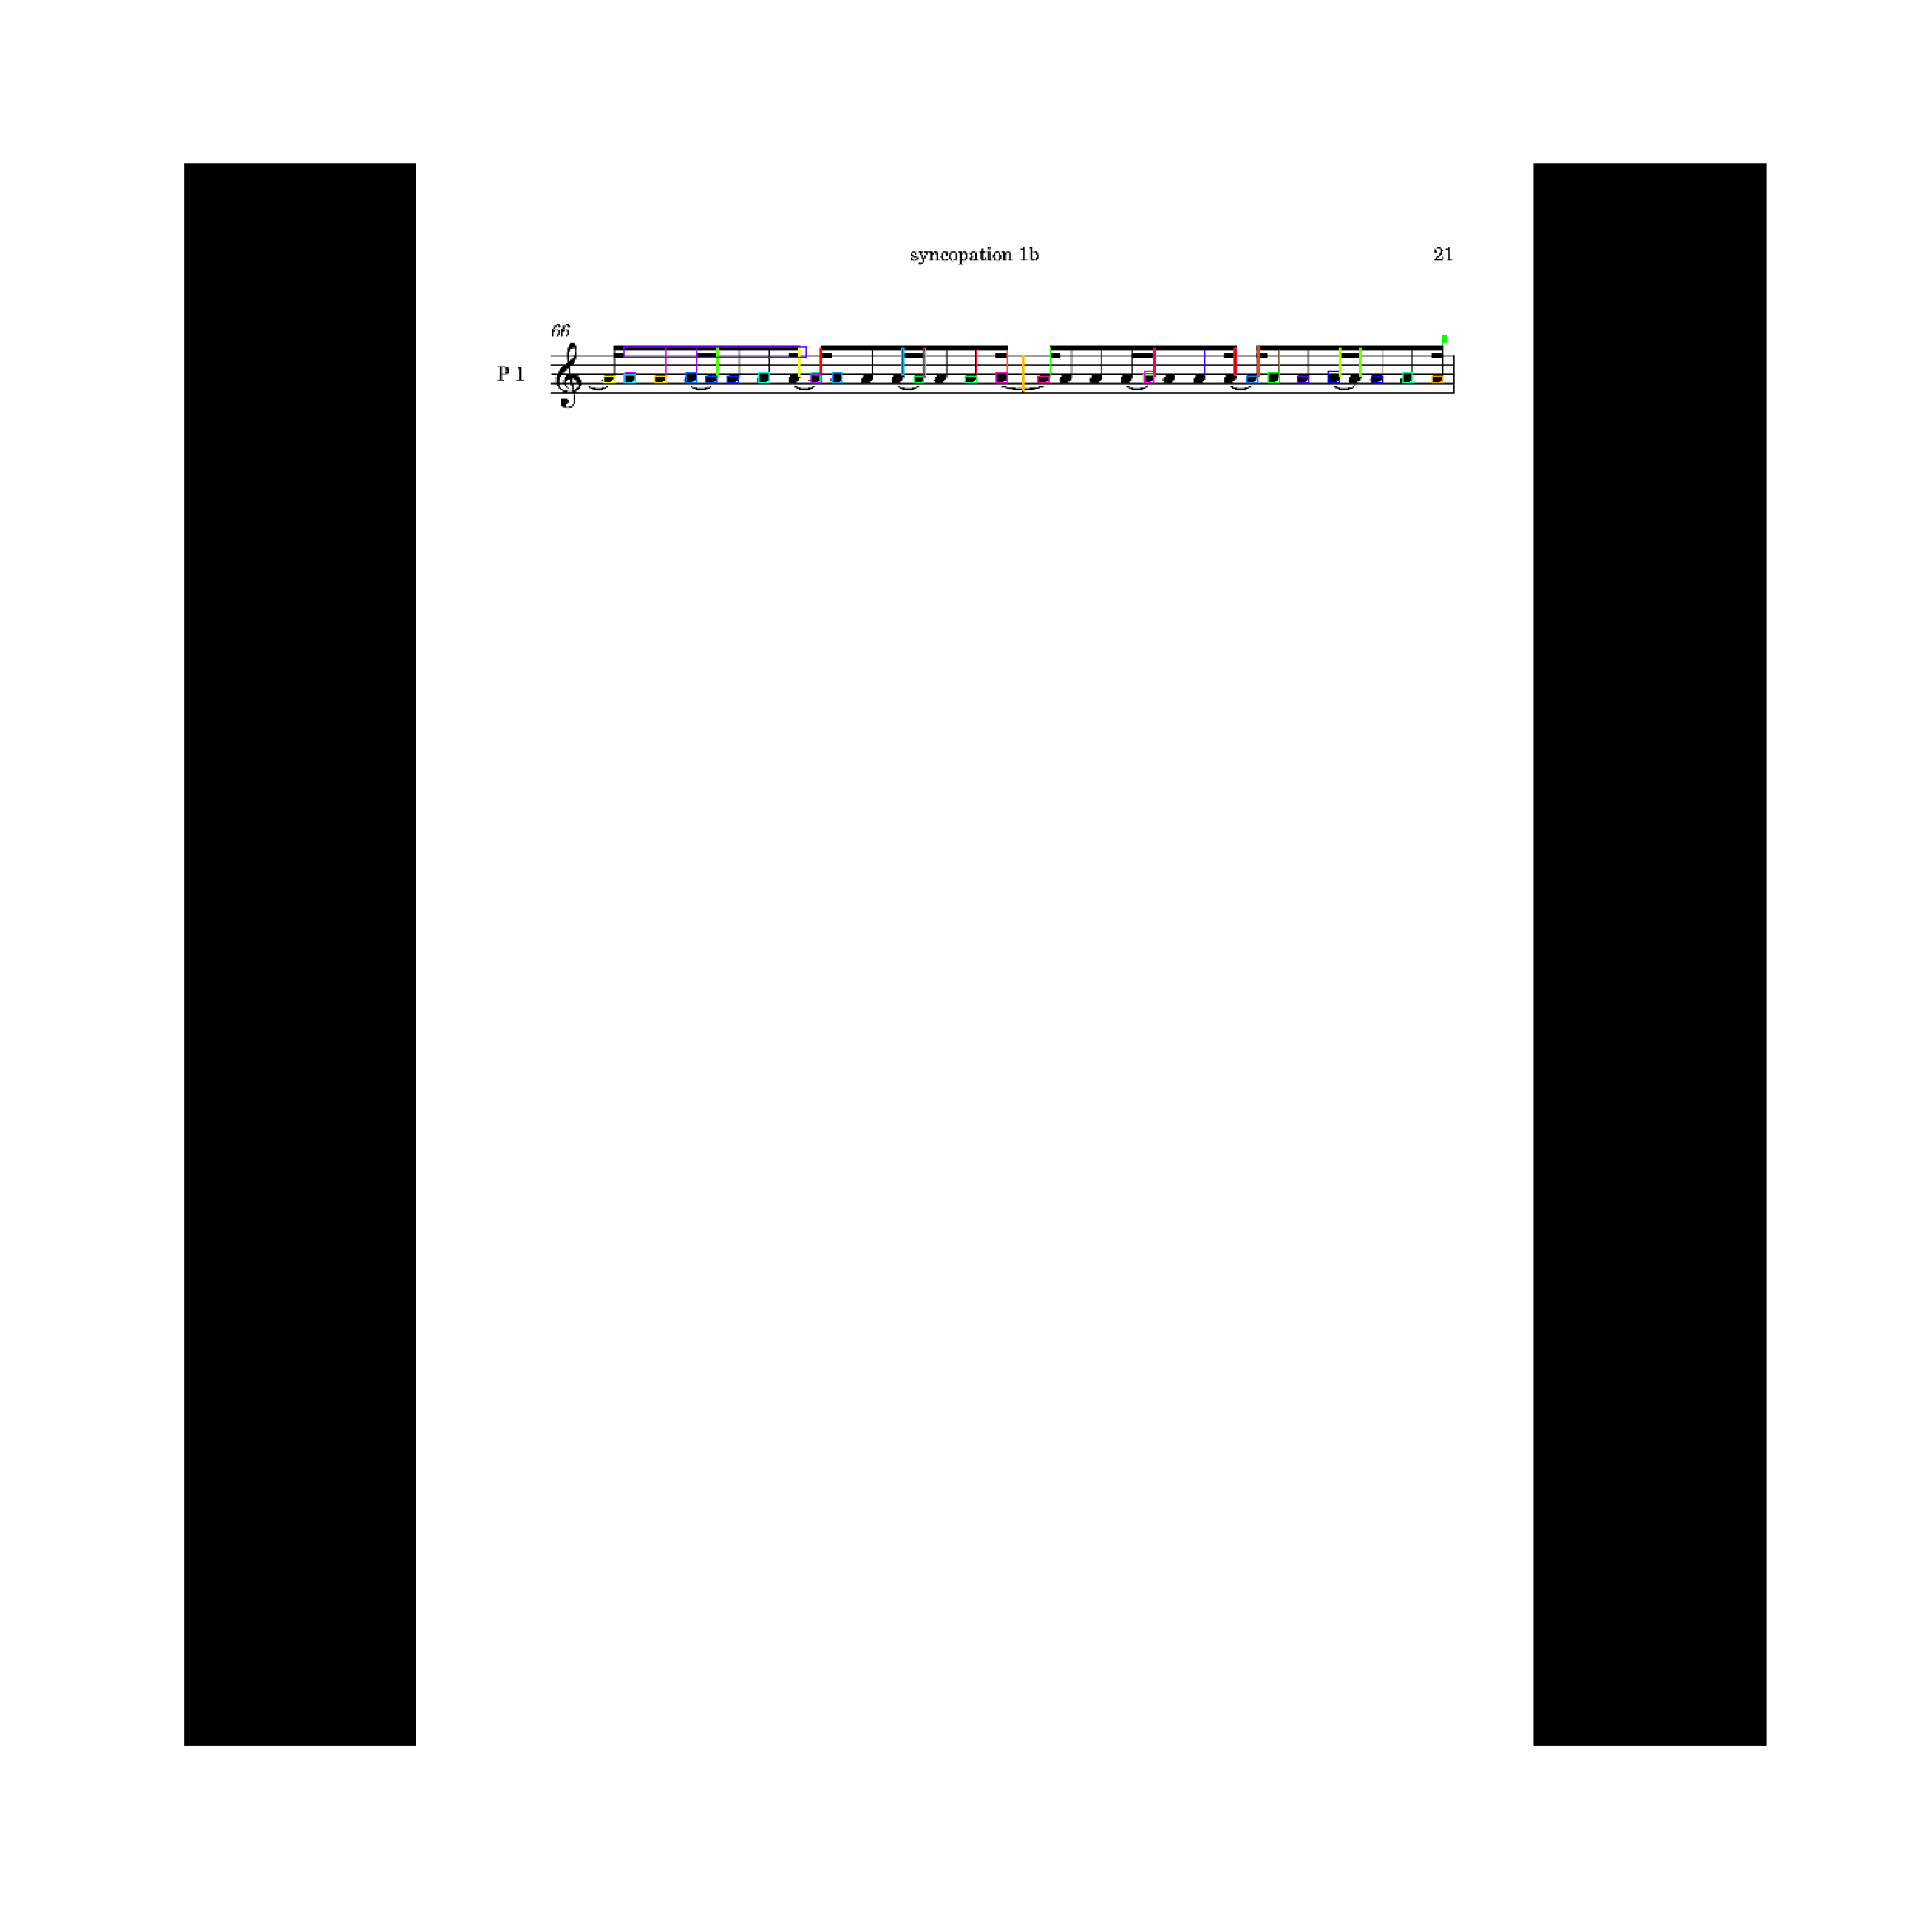

In [40]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = DoremiConfig.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

# Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

## 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [41]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_train.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_train.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

# 2.c Step by Step Detection

In [ ]:
# Preprocessing on detections

# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = DoremiConfig.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_train.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

In [ ]:
# Apply box refinment 

# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * DoremiConfig.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

## Filter Low Confidence Detections


In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= DoremiConfig.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    DoremiConfig.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

## Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            DoremiConfig.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_train.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks
This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

## 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

## 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_train.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

# Visualize Activations

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],DoremiConfig))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
